#Assignment 6 - classification with Spark

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("ex6") \
       .getOrCreate()

spark

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,542 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,183 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/univers

###Data load

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bank_data.csv to bank_data.csv


In [ ]:
bank_data = spark.read.csv(path='bank_data.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True,
                        inferSchema=True)
bank_data.show(n=5, truncate=False)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1       |-1   |0       |unknown |yes    |
|56 |admin.    |married|secondary|no     |45     |no     |no  |unknown|5  |may  |1467    |1       |-1   |0       |unknown |yes    |
|41 |technician|married|secondary|no     |1270   |yes    |no  |unknown|5  |may  |1389    |1       |-1   |0       |unknown |yes    |
|55 |services  |married|secondary|no     |2476   |yes    |no  |unknown|5  |may  |579     |1       |-1   |0       |unknown |yes    |
|54 |admin.    |married|tertiary |no     |184    |no     |no  |unknown|5  |m

In [ ]:
cols = bank_data.columns
rows = bank_data.count()
rows

11162

In [ ]:
# no missing values
from pyspark.sql.functions import isnan, when, count, col
bank_data.select([count(when(isnan(c), c)).alias(c) for c in bank_data.columns]).show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|      0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

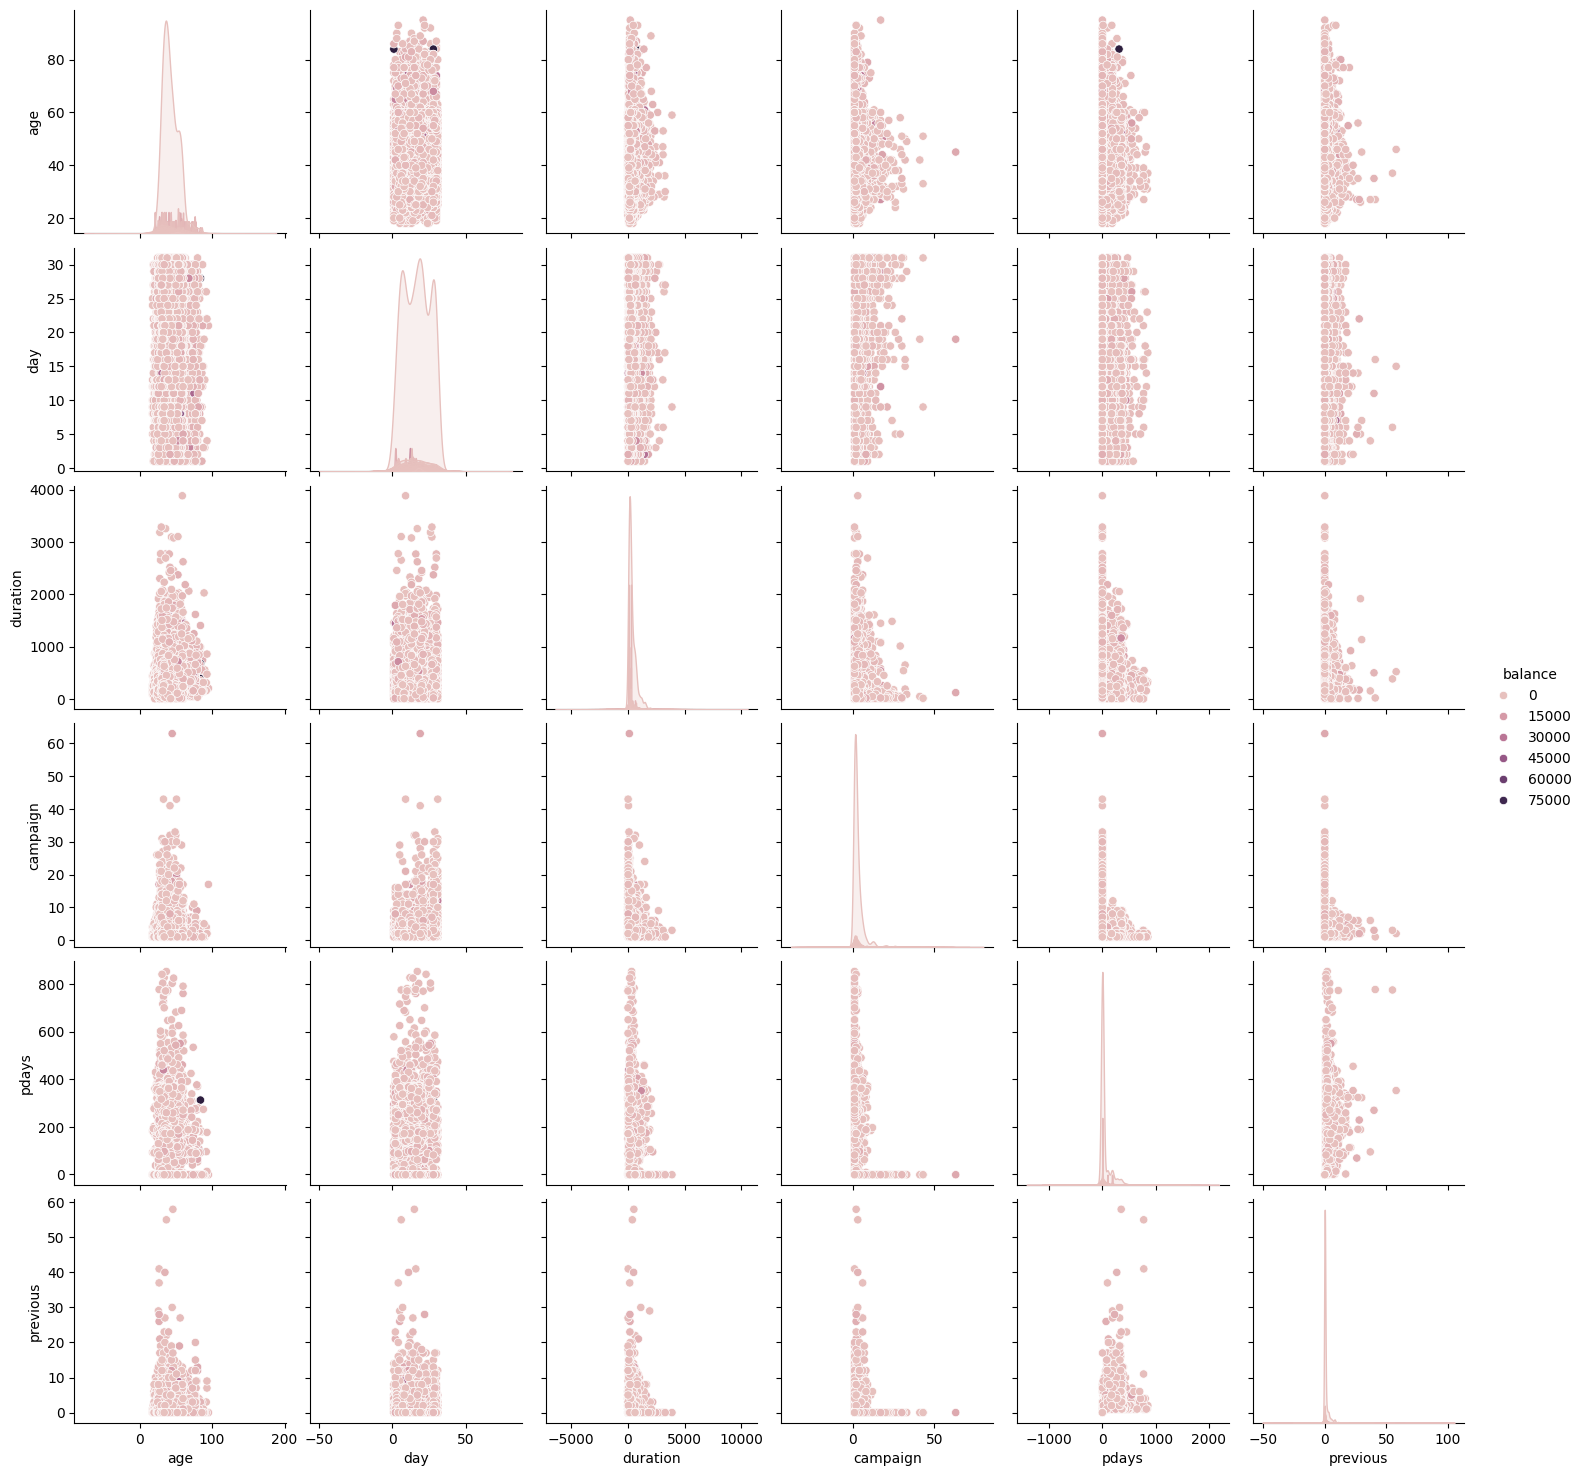

In [ ]:
bank_data_pd = bank_data.toPandas()
sns.pairplot(bank_data_pd, hue='balance')

Text(0.5, 1.0, 'Correlation heatmap')

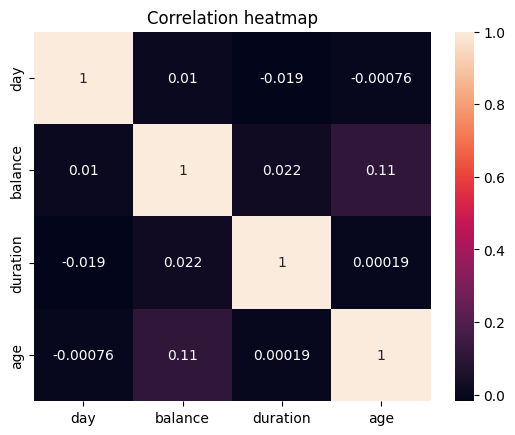

In [ ]:
bank_data_corr = bank_data_pd[["day", "balance", "duration", "age"]].dropna().corr()
sns.heatmap(bank_data_corr, annot=True)
plt.title("Correlation heatmap")

In [ ]:
unique_deposit_values = bank_data.select("deposit").distinct().rdd.map(lambda row: row[0]).collect()
class_names = [value for value in unique_deposit_values]
print(class_names)

['no', 'yes']


In [ ]:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# Stages list to collect our transformations
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index', handleInvalid="skip")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
stages

[StringIndexer_eabf7c3bffa8,
 OneHotEncoder_7700969d17ad,
 StringIndexer_abbf4d2af2d7,
 OneHotEncoder_3ebdf06f9b2a,
 StringIndexer_497761793a9f,
 OneHotEncoder_a55a733dbcf9,
 StringIndexer_c36c536ecf92,
 OneHotEncoder_ed8fcbfc7190,
 StringIndexer_a997c48dc376,
 OneHotEncoder_244ebceb7ef6,
 StringIndexer_edd0a84b082a,
 OneHotEncoder_64d83e641a14,
 StringIndexer_e0cb0108a802,
 OneHotEncoder_c43c16f52c5b,
 StringIndexer_eb9b78d94695,
 OneHotEncoder_08334c2bc5ca]

In [ ]:
label_stringIdx = StringIndexer(inputCol='deposit', outputCol='label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(bank_data)
df = pipelineModel.transform(bank_data)

selectedCols = ['label', 'features']
df = df.select(selectedCols)

df.printSchema()
df.show(5)

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[2,11,13,16,1...|
|  1.0|(30,[4,11,13,16,1...|
|  1.0|(30,[3,11,14,16,1...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df)
data = featureIndexer.transform(df)

data.show(5, True)

+-----+--------------------+--------------------+
|label|            features|     indexedFeatures|
+-----+--------------------+--------------------+
|  1.0|(30,[3,11,13,16,1...|(30,[3,11,13,16,1...|
|  1.0|(30,[3,11,13,16,1...|(30,[3,11,13,16,1...|
|  1.0|(30,[2,11,13,16,1...|(30,[2,11,13,16,1...|
|  1.0|(30,[4,11,13,16,1...|(30,[4,11,13,16,1...|
|  1.0|(30,[3,11,14,16,1...|(30,[3,11,14,16,1...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#Split data
train_data, test_data = data.randomSplit([0.8, 0.2])
train_data.show(5)
test_data.show(5)

+-----+--------------------+--------------------+
|label|            features|     indexedFeatures|
+-----+--------------------+--------------------+
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
+-----+--------------------+--------------------+
only showing top 5 rows

+-----+--------------------+--------------------+
|label|            features|     indexedFeatures|
+-----+--------------------+--------------------+
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
+-----+--------------------+--------------------+
only showing top 5 rows



###Model example and 3 Classifications

In [ ]:
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='label')

In [ ]:
logr_model = logr.fit(train_data)

In [ ]:
summary = logr_model.summary

# Performance Metrics
print("Performance Metrics:")
print(f"Accuracy: {summary.accuracy}")
print(f"Precision by label: {summary.precisionByLabel}")
print(f"Recall by label: {summary.recallByLabel}")
print(f"F1 score by label: {summary.fMeasureByLabel()}")
print(f"Area Under ROC: {summary.areaUnderROC}")

# Coefficients and Intercept
print("\nCoefficients and Intercept:")
print(f"Coefficients: {logr_model.coefficients}")
print(f"Intercept: {logr_model.intercept}")

# Summary Statistics
print("\nSummary Statistics:")
print(f"Objective History: {summary.objectiveHistory}")
print(f"Total Iterations: {summary.totalIterations}")
print(f"Area Under ROC: {summary.areaUnderROC}")

# Show ROC and PR curves
print("\nROC and Precision-Recall Curves:")
summary.roc.show()
summary.pr.show()


Performance Metrics:
Accuracy: 0.8091956619972888
Precision by label: [0.8028688524590164, 0.8169687814702921]
Recall by label: [0.8434876210979548, 0.7713334917993819]
F1 score by label: [0.8226771653543307, 0.7934955373517544]
Area Under ROC: 0.8896104268271922

Coefficients and Intercept:
Coefficients: [0.2921744335389227,0.25451507942235235,0.4068382339109173,0.636737091849481,0.20175849004537652,1.0456412631404517,0.1381697566532063,1.274299992144363,0.43263329381781496,0.09868830695714281,-0.03087901990203782,-0.09065584219088156,0.13648966319655867,-0.06103314384247823,0.20579170232658853,-0.3106817377496264,0.14739442395216173,0.9216949049988735,0.707125785145215,-0.025453176467541267,-1.2402749651816964,-0.6662100526555734,-0.17559603639846938,1.9420974785930616,-0.002655162567909845,3.525208329142646e-05,0.005373468325359534,-0.11943540215329361,-2.811886884059513e-05,0.004287310684471285]
Intercept: -2.6731299415839223

Summary Statistics:
Objective History: [0.6919225283611

In [ ]:
logr_predict = logr_model.transform(test_data)

In [ ]:
logr_predict.select("features","label","rawPrediction","prediction","probability").show(5)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(30,[0,11,13,16,1...|  0.0|[2.06735602259300...|       0.0|[0.88768963557143...|
|(30,[0,11,13,16,1...|  0.0|[0.86100408263475...|       0.0|[0.70287039328632...|
|(30,[0,11,13,16,1...|  0.0|[1.14129102856869...|       0.0|[0.75791659454152...|
|(30,[0,11,13,16,1...|  0.0|[1.07875343811155...|       0.0|[0.74625801059634...|
|(30,[0,11,13,16,1...|  0.0|[3.13410665322164...|       0.0|[0.95827789193359...|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [ ]:
logr_bn_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC:', logr_bn_evaluator.evaluate(logr_predict))


Test Area Under ROC: 0.8767046788731203


Text(0.5, 1.0, 'ROC Curve')

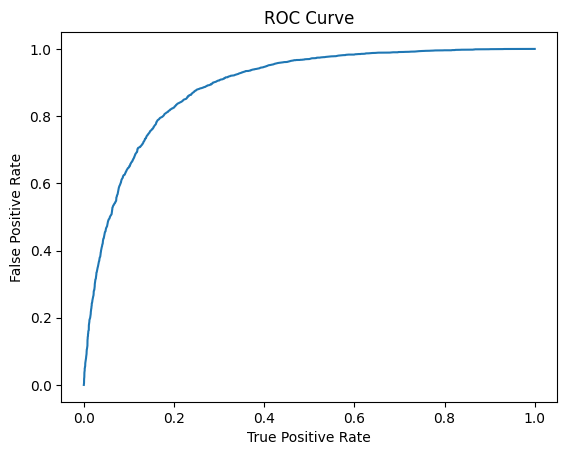

In [ ]:
roc = logr_model.summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

In [ ]:
y_true = logr_predict.select("label")
y_true = y_true.toPandas()
y_pred = logr_predict.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[1026,  202],
       [ 263,  819]])

Text(0.5, 1.0, 'CM of LR Model')

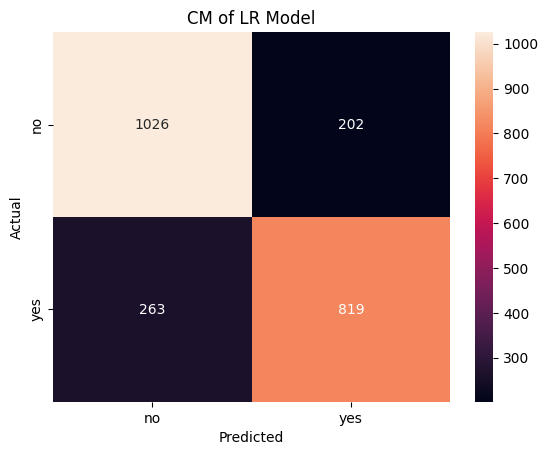

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CM of LR Model')

###Decision Tree Classification

In [ ]:
dt = DecisionTreeClassifier(featuresCol='indexedFeatures', labelCol='label')

In [ ]:
dt_model = dt.fit(train_data)

In [ ]:
dt_predict = dt_model.transform(test_data)

In [ ]:
dt_predict.select("features","label","rawPrediction","prediction","probability").show(5)

+--------------------+-----+--------------+----------+--------------------+
|            features|label| rawPrediction|prediction|         probability|
+--------------------+-----+--------------+----------+--------------------+
|(30,[0,11,13,16,1...|  0.0|[1500.0,109.0]|       0.0|[0.93225605966438...|
|(30,[0,11,13,16,1...|  0.0| [517.0,262.0]|       0.0|[0.66367137355584...|
|(30,[0,11,13,16,1...|  0.0|[1500.0,109.0]|       0.0|[0.93225605966438...|
|(30,[0,11,13,16,1...|  0.0|  [434.0,34.0]|       0.0|[0.92735042735042...|
|(30,[0,11,13,16,1...|  0.0|[1500.0,109.0]|       0.0|[0.93225605966438...|
+--------------------+-----+--------------+----------+--------------------+
only showing top 5 rows



In [ ]:
dt_bn_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC:', dt_bn_evaluator.evaluate(dt_predict))

Test Area Under ROC: 0.7891955722001118


In [ ]:
y_true = dt_predict.select("label")
y_true = y_true.toPandas()
y_pred = dt_predict.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[957, 271],
       [223, 859]])

Text(0.5, 1.0, 'CM of Decision Tree Model')

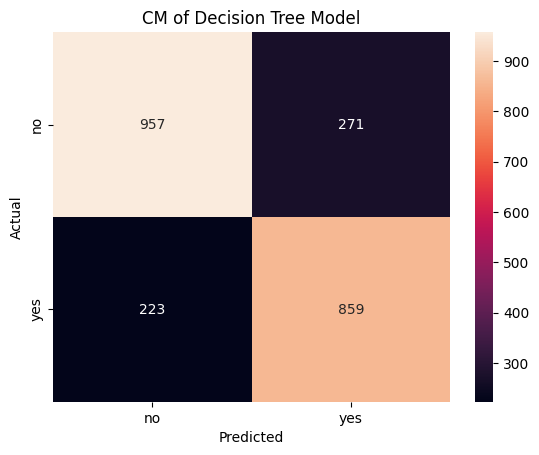

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CM of Decision Tree Model')

###Random Forest Classification

In [ ]:
rf = RandomForestClassifier(featuresCol='indexedFeatures', labelCol='label')

In [ ]:
rf_model = rf.fit(train_data)

In [ ]:
rf_predict = rf_model.transform(test_data)

In [ ]:
rf_predict.select("features","label","rawPrediction","prediction","probability").show(5)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(30,[0,11,13,16,1...|  0.0|[15.2506964355409...|       0.0|[0.76253482177704...|
|(30,[0,11,13,16,1...|  0.0|[13.6794341663140...|       0.0|[0.68397170831570...|
|(30,[0,11,13,16,1...|  0.0|[14.8282855770480...|       0.0|[0.74141427885240...|
|(30,[0,11,13,16,1...|  0.0|[14.1679759767767...|       0.0|[0.70839879883883...|
|(30,[0,11,13,16,1...|  0.0|[16.2915701227930...|       0.0|[0.81457850613965...|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [ ]:
rf_bn_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC:', rf_bn_evaluator.evaluate(rf_predict))

Test Area Under ROC: 0.8729321831329392


In [ ]:
y_true = rf_predict.select("label")
y_true = y_true.toPandas()
y_pred = rf_predict.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[1000,  228],
       [ 250,  832]])

Text(0.5, 1.0, 'CM of Random Forest Model')

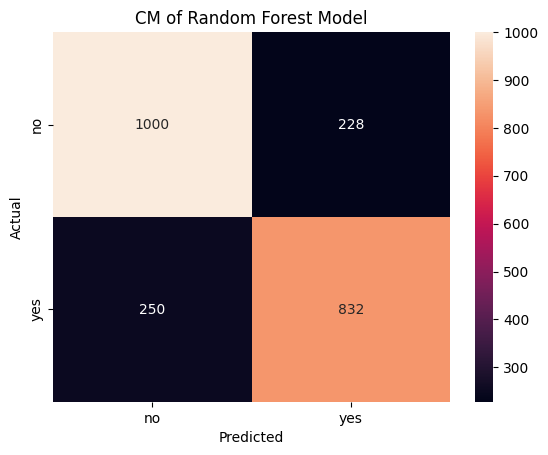

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CM of Random Forest Model')